<a href="https://colab.research.google.com/github/yandod/machine-learning-examples/blob/main/03_dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

出典: http://cedro3.com/ai/dream-booth/

このノートにはGPUインスタンスが必要です (T4 GPUで動作確認済み)

# Colabのバージョンアップに伴う環境調整

In [1]:
#@title CUDA 11.8 のインストール　(所要時間 4分)
!apt-get update
!apt-get install cuda-toolkit-11-8
import os
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11/lib64"
os.environ["LD_LIBRARY_PATH"] += ":" + "/usr/local/cuda-11.8/lib64"

!unlink /usr/local/cuda
!ln -s /usr/local/cuda-11.8 /usr/local/cuda

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Fetched 2,351 kB in 4s (637 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information

In [2]:
#@title CUDAの確認 (Colabの初期値は12.2系)
!ls -d /usr/local/cuda-*
!which nvcc

/usr/local/cuda-11  /usr/local/cuda-11.8  /usr/local/cuda-12  /usr/local/cuda-12.2
/usr/local/cuda/bin/nvcc


In [3]:
#@title CUDAの影響のあるパッケージを更新 (所要時間 6分)

# torchのバージョンを変更
#%pip uninstall -y torch torchvision xformers accelerate torchaudio torchtext tensorflow
%pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 torchtext==0.16.0 --index-url https://download.pytorch.org/whl/cu118

# Colabのバージョンアップがあったモジュールの調整
%pip install "jax[cuda11_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#%pip install xformers==0.0.18
%pip install xformers==0.0.22.post4 --index-url https://download.pytorch.org/whl/cu118
%pip install -q accelerate transformers==4.35.2 ftfy bitsandbytes==0.35.0 gradio natsort safetensors tensorflow==2.15.0 tensorrt-cu11



Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 401.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Suc

# dreamboothのセットアップ関係

In [4]:
#@title #**dreambooth のインストール** (所要時間 1分)
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton==2.1.0


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
#@title #**HuggingFaceへのログイン**

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

In [6]:
#@title #**フォルダの設定**

# define function
import os
import shutil
def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob
def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)
        fig.tight_layout()
    plt.show()
    plt.close()

# setting
MODEL_NAME = "CompVis/stable-diffusion-v1-4"

INSTANCE = "yando"#@param {type:"string"}
INSTANCE_DIR = "/content/data/"+INSTANCE
reset_folder(INSTANCE_DIR)

CLASS = "portrait" #@param {type:"string"}
CLASS_DIR = "/content/data/"+CLASS
reset_folder(CLASS_DIR)

OUTPUT_DIR = "/content/stable_diffusion_weights/" + INSTANCE
reset_folder(OUTPUT_DIR)


concepts_list = [
    {
        "instance_prompt":      INSTANCE,
        "class_prompt":         CLASS,
        "instance_data_dir":     INSTANCE_DIR,
        "class_data_dir":        CLASS_DIR
    },
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

# 画像モデルの学習

In [ ]:
#@title #**学習に利用する画像のアップロード**
import os
from google.colab import files
import shutil
import gdown

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

%matplotlib inline
display_pic(INSTANCE_DIR)

In [9]:
#@title #**学習** (takes 15minutes)
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt=$CLASS \
  --concepts_list="concepts_list.json"


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-05-18 09:52:34.152280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 09:52:34.152329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 09:52:34.281242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

In [10]:
#@title #**画像生成処理の準備**

# Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = ""
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR.rstrip(os.sep)+"/*"))[-1]

# Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
#pipe.enable_xformers_memory_efficient_attention()

g_cuda = None

# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52222 #@param {type:"number"}
g_cuda.manual_seed(seed)

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


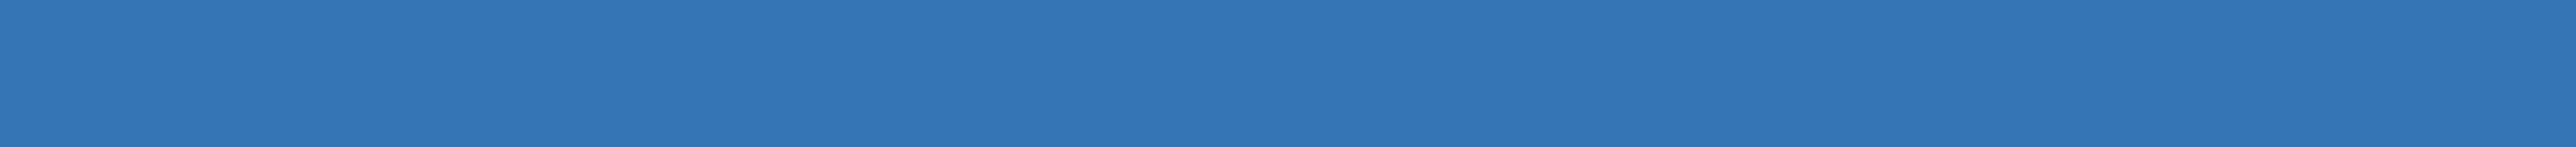

  0%|          | 0/50 [00:00<?, ?it/s]

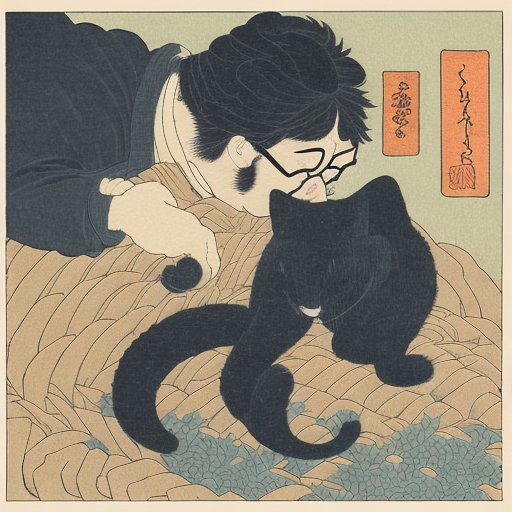

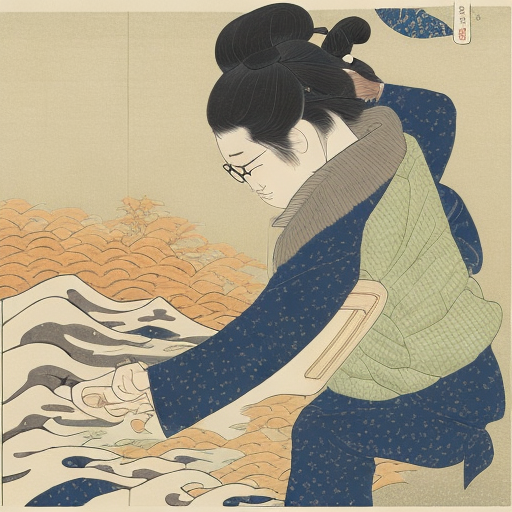

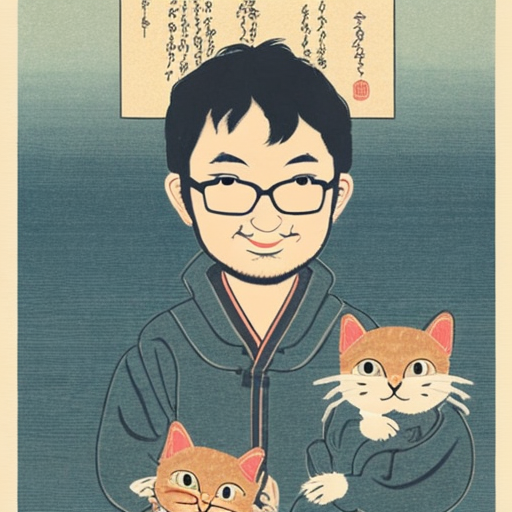

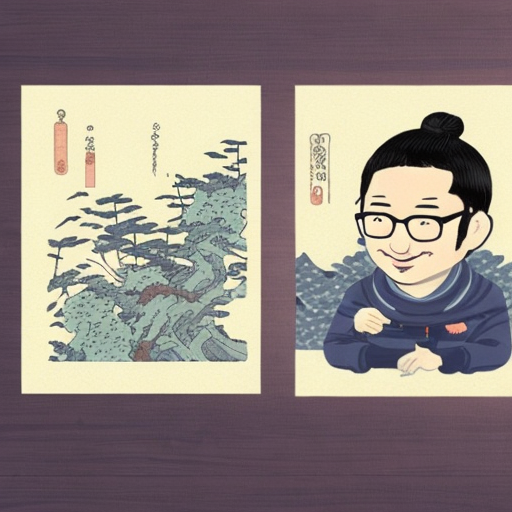

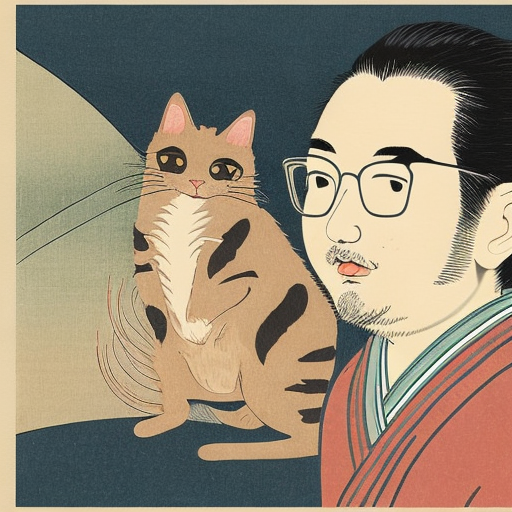

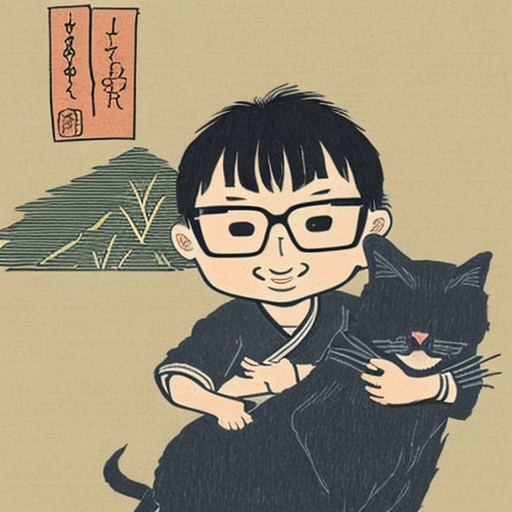

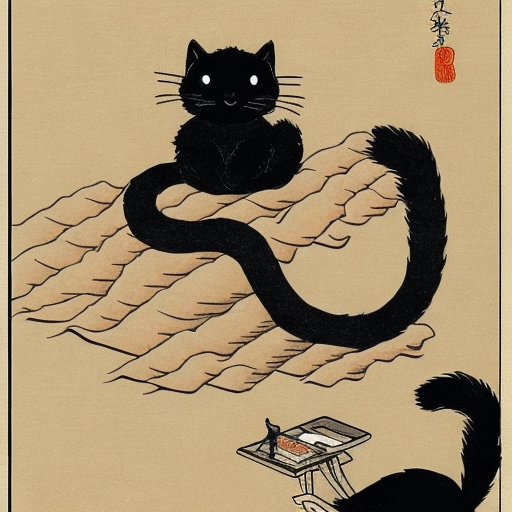

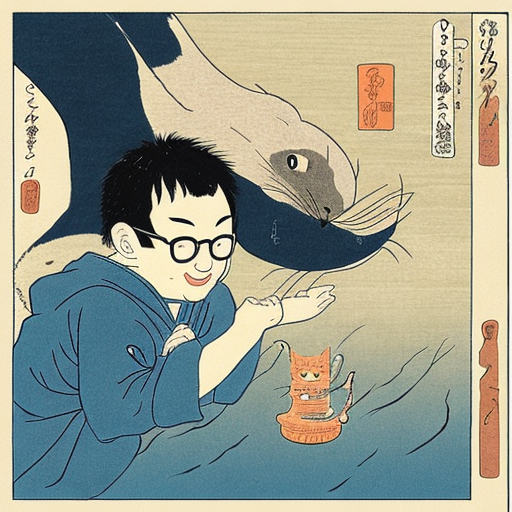

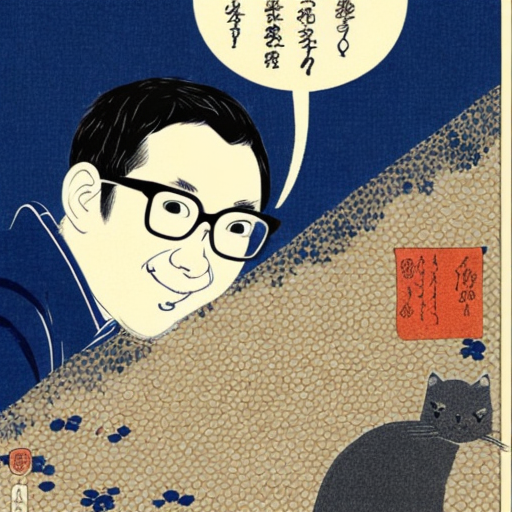

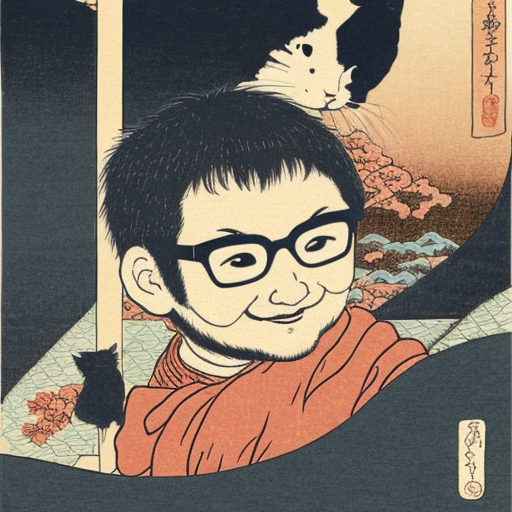

In [11]:
#@title #**画像の生成**

reset_folder('images')

# prompt
prompt = "yando and cat in hokusai style" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}

# other setting
num_samples = 10
guidance_scale = 7.5
num_inference_steps = 50
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    display(img)

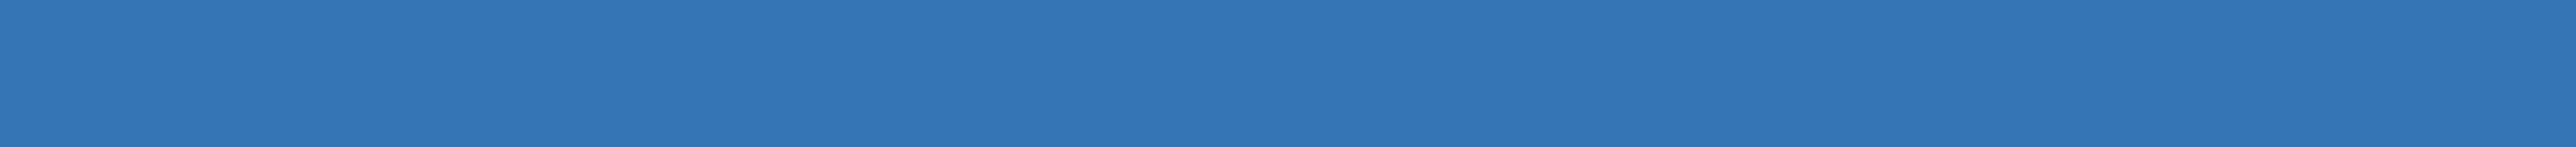